In [461]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import (Vectorizer,SlidingEstimator,
                          cross_val_multiscore, LinearModel, 
                          get_coef)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 

In [462]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [463]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [464]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [465]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [466]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [467]:
epoch

<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

In [468]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim .events.shape

(5424, 3)

In [469]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [470]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [471]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([27806,     0,   100]),
 array([27931,     0,   100]),
 array([28060,     0,   100]),
 array([28521,     0,   100]),
 array([28646,     0,   100]),
 array([28775,     0,   100]),
 array([29292,     0,   100]),
 array([29417,     0,   100]),
 array([29546,     0,   100]),
 array([29826,     0,   100]),
 array([29951,     0,   100]),
 array([30080,     0,   100]),
 array([30752,     0,   100]),
 array([30876,     0,   100]),
 array([31006,     0,   100]),
 array([31406,     0,   100]),
 array([31531,     0,   100]),
 array([31660,     0,   100]),
 array([31940,     0,   100]),
 array([32065,     0,   100]),
 array([32194,     0,   100]),
 array([32646,     0,   100]),
 array([32771,     0,   100]),
 array([32900,     0,   100]),
 array([33383,     0,   100]),
 array([33508,     0,   100]),
 array([33637,     0,   100]),
 array([35463,     0,   100]),
 array([35587,     0,   100]),
 array([35717,     0,   100]),
 array([36328,     0,   100]),
 array([36453,     0,   100]),
 array([

In [472]:
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [473]:
type(test)

mne.epochs.EpochsFIF

In [474]:
epochWnewStim.get_data().shape

(5424, 129, 180)

In [475]:
type(epochWnewStim)

mne.epochs.EpochsFIF

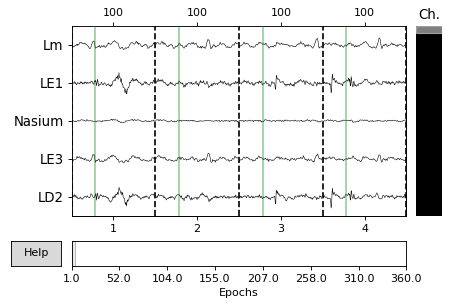

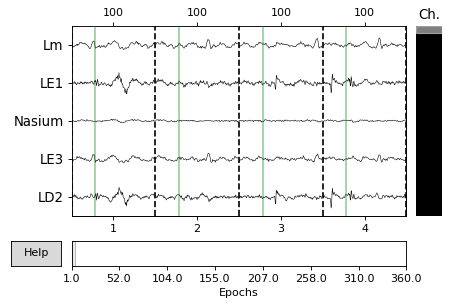

In [476]:
test.plot(n_channels=5,n_epochs=4)

In [477]:
test.get_data().shape

(360, 129, 180)

In [478]:
from sklearn.cross_validation import train_test_split
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




shape of data (360, 129, 180)
shape of target array (360,)


In [479]:
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression())

cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    clf.fit(X_train,y_train)
    #print("shape of 2D data",Vectorizer().fit_transform(X_train).shape)
    #probability for each class on sample
    #proba = clf.predict_proba(X_test)
    #print(proba)
    
    #confidence score per sample where >0 means self.classes[1] will be predicted
    #print(clf.decision_function(X_test))
    #array classes(binary event_id)
    #print(clf.classes_)
    y_preds = clf.predict(X_test)
    y_preds = np.array(y_preds)
    threshold,visual,audio = 100,0,1
    binary_y_preds = np.where(y_preds > threshold, audio,visual)
    #print(binary_y_preds)
    #print(y_preds)
    y_testNP = np.array(y_test)
    #threshold,visual,audio = 100,0,1
    binary_y_test = np.where(y_testNP > threshold, audio,visual)
    #print(binary_y_test)
    
    #print(set(y_test))
#     fpr,tpr,threshold = metrics.roc_curve(y_test,binary_y_preds)
#     tprs.append(interp(mean_fpr,fpr,tpr))
#     tprs[-1][0] = 0.0
#     roc_auc = metrics.auc(fpr,tpr)
#     aucs.append(roc_auc)
    
#     plt.plot(fpr, tpr, lw=1, alpha=0.3,
#              label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

#     i += 1
#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#              label='Chance', alpha=.8)

#     mean_tpr = np.mean(tprs, axis=0)
#     mean_tpr[-1] = 1.0
#     mean_auc = auc(mean_fpr, mean_tpr)
#     std_auc = np.std(aucs)
#     plt.plot(mean_fpr, mean_tpr, color='b',
#              label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#              lw=2, alpha=.8)

#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                      label=r'$\pm$ 1 std. dev.')

#     plt.xlim([-0.05, 1.05])
#     plt.ylim([-0.05, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()
    
    score.append(clf.score(X_test,y_test))
    
    
    




In [480]:
test.times.shape

AttributeError: 'numpy.ndarray' object has no attribute 'times'

In [ ]:
print("mean classification score", np.mean(score))

In [ ]:
test.times.shape

In [ ]:
#decoding over time. We are using the last dimension in
#features_data (n_epochs x n_channels x n_times) to fit
#Linear model in each time instance and evaluate performance 
#on same instance for new epochs
clf2 = make_pipeline(StandardScaler(),LinearModel(LogisticRegression(C=1)))
time_decod = SlidingEstimator(clf2,n_jobs=1,scoring='roc_auc')
scores = cross_val_multiscore(time_decod,features_data,target_V_vs_A, cv =5, n_jobs=1)
scores = np.mean(scores, axis=0)
# Plot
fig, ax = plt.subplots()
ax.plot(test.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

In [484]:
time_decod.fit(features_data,target_V_vs_A)
patterns = get_coef(time_decod, 'patterns_', inverse_transform=False)
patterns.shape

(129, 180)

In [485]:
df = pd.DataFrame(patterns)
df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.202025,0.063031,0.215908,0.033285,-0.042818,-0.098513,0.227387,0.406789,-0.056011,-0.142845,...,0.135481,-0.026237,-0.550430,0.299128,0.280123,-0.252351,0.282814,0.301544,0.116700,0.063977
1,0.110594,0.350748,0.481162,0.121879,0.192075,-0.332421,-0.048727,0.443190,0.100218,-0.281038,...,0.062741,0.039726,-0.537446,-0.253664,0.307722,0.098948,0.341315,0.009363,-0.068453,0.139849
2,0.084828,0.089076,0.420222,0.397595,0.379329,-0.249380,0.292427,0.603957,-0.114117,-0.035188,...,-0.194226,-0.450968,-0.421541,0.078345,0.214905,0.057136,0.096528,-0.073476,-0.026372,0.170585
3,0.200303,0.122500,0.193085,0.226794,-0.160570,0.061470,0.233552,-0.091435,0.012518,0.081658,...,0.251963,0.020292,-0.561131,0.135875,0.223818,-0.108304,0.105442,0.310789,0.415071,0.225960
4,0.350754,0.249985,-0.022731,0.204563,0.236924,-0.324746,0.021623,0.189828,0.231709,-0.446189,...,0.215806,0.018102,-0.740051,-0.543850,0.657679,0.280481,0.497751,-0.050842,-0.107234,0.464574
5,0.139176,0.141900,-0.115894,0.118872,-0.087709,-0.022227,-0.487367,-0.609648,0.162888,0.407316,...,0.269179,0.244009,-0.155730,-0.308080,0.321857,0.191083,-0.139817,-0.038592,0.248497,0.160710
6,0.006393,0.265231,-0.036648,0.322533,0.174344,-0.417314,-0.329300,-0.110638,0.363937,0.222191,...,-0.462899,0.164939,0.254726,-0.634773,0.796843,0.148815,0.114663,-0.265944,0.127694,0.636477
7,-0.013397,0.079476,-0.022017,-0.186663,0.184897,-0.104069,0.062368,0.749135,0.323218,0.373117,...,0.190943,-0.028294,-0.627319,-0.413490,0.432585,0.017576,-0.059675,0.124411,0.244560,0.330986
8,0.524659,0.058405,0.225205,0.084824,-0.364627,-0.369408,-0.166310,-0.488943,-0.115481,0.111884,...,-0.203876,0.187725,0.549137,0.231513,-0.135220,-0.127554,-0.284694,0.113839,-0.038103,-0.223592
9,-0.322888,-0.222588,0.253915,0.181966,-0.174089,-0.082483,0.036933,-0.649784,0.061618,0.256196,...,-0.063549,-0.210932,0.178557,-0.206559,-0.284114,-0.218156,-0.226440,-0.014420,0.042035,-0.469290


In [178]:
aaa = Vectorizer().fit_transform(features_data)
aaa.shape


(360, 23220)

In [212]:
df = pd.DataFrame(aaa)

In [213]:
df

,0,1,2,3,4,5,6,7,8,9,...,23210,23211,23212,23213,23214,23215,23216,23217,23218,23219
0,-3.921823e-06,-5.571442e-06,-7.366096e-06,-6.524563e-06,-4.005347e-06,-3.862769e-06,-4.859965e-06,-2.718158e-06,-1.742042e-06,-1.764748e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
1,4.585151e-07,1.334955e-06,1.721369e-06,5.151453e-06,5.680569e-06,5.037848e-06,5.773264e-06,4.190741e-06,2.187261e-06,1.780399e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-5.445867e-06,-3.173985e-06,-2.885827e-06,-3.581341e-06,-1.680603e-06,-1.934519e-06,-4.541460e-07,-5.035362e-07,4.782355e-07,2.201315e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.445486e-06,-2.589277e-06,-1.189872e-06,-3.303565e-07,5.270368e-07,2.938219e-06,3.698142e-06,3.139596e-06,2.568221e-06,2.410926e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
4,2.077913e-06,-4.561307e-06,-8.878198e-06,-7.208122e-06,-2.337705e-06,-4.857510e-07,9.799401e-07,-1.008280e-06,3.965988e-07,2.658183e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-6.146129e-06,-9.847182e-06,-6.794071e-06,-4.943444e-06,-4.647918e-06,-3.284984e-06,-2.845580e-06,-3.298798e-06,-3.530485e-06,-7.771520e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.716986e-06,3.479391e-06,5.858217e-06,3.656822e-06,3.723697e-06,5.513758e-06,4.253008e-07,-6.206208e-07,-5.964056e-07,-3.299895e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
7,-1.290905e-06,-2.114264e-06,2.794255e-07,2.869302e-06,1.859287e-06,-1.398569e-06,-2.871440e-06,-2.927482e-06,-1.053195e-06,4.657122e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.998460e-06,4.963545e-06,3.714679e-06,2.574560e-06,2.197050e-06,1.708264e-06,-3.167101e-07,1.152561e-06,1.841309e-06,-8.437510e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-5.850758e-06,-4.454986e-06,7.864037e-07,1.603537e-06,1.618401e-07,-1.447479e-06,-1.225500e-06,-4.779112e-07,-2.383629e-06,-4.583182e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0


In [181]:
clf.classes_

array([100, 200])

In [182]:
print(metrics.r2_score(target_test,y_pred))

-0.24401913875598047


array([-4.1920613 , -4.77514058, -0.49106324, -0.22338122,  0.38171083,
        1.74602437, -2.54455606, -2.08286078, -2.95095634, -4.26044356,
       -4.0761867 ,  0.43578667, -2.23397378, -3.57802828, -4.00813011,
       -1.94200906, -3.12121567, -2.13596743,  0.8847367 , -3.21826793,
       -3.13581339, -6.95525329, -5.96633699, -2.35855757,  0.85819578,
       -4.3996523 , -4.3480659 ,  0.63356524, -3.29634454,  3.07940347,
       -0.75305579, -3.27642697, -2.89811734, -1.02155945, -0.8655743 ,
       -0.51790452, -5.10860724, -2.04640956,  1.65945086, -0.72419167,
       -3.39436976, -1.30994811,  0.77474607, -3.85220964,  1.95538628,
       -4.21256811, -7.22996304, -3.43662088, -0.05139956,  1.34315264,
       -3.78605912, -3.88440506, -3.42619506, -0.13859775, -4.69572278,
        1.41365962,  3.00351893, -3.52699453, -0.13780543,  0.87812066,
       -0.9545848 ,  2.67623701, -3.18021571, -7.13119845, -1.43287455,
       -2.62933268, -5.52677051, -2.46194502, -4.69322439, -0.02